# Setup

In [1]:
!git clone https://github.com/wlg1/univ_feat_geom.git

Cloning into 'univ_feat_geom'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 347 (delta 15), reused 35 (delta 8), pack-reused 293 (from 1)
Receiving objects: 100% (347/347), 252.16 MiB | 35.85 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Updating files: 100% (151/151), done.


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

## load weight mats

Temporarily loading data from repo for convenience; larger files in the future will used a better storage system and not a repo

In [3]:
file_path = '/content/univ_feat_geom/data/Wdec_ts_1L_21M_df16384_steps100k.pkl'
with open(file_path, 'rb') as f:
    weight_matrix_1 = pickle.load(f)
weight_matrix_1 = weight_matrix_1.detach().numpy()
print(weight_matrix_1.shape)

(16384, 1024)


In [4]:
file_path = '/content/univ_feat_geom/data/Wdec_ts_2L_33M_df16384_steps100k.pkl'
with open(file_path, 'rb') as f:
    weight_matrix_2 = pickle.load(f)
weight_matrix_2  = weight_matrix_2.detach().numpy()
print(weight_matrix_2.shape)

(16384, 1024)


## Comparison Functions

In [5]:
def compare_singular_values(S1, S2):
    l2_distance = np.linalg.norm(S1 - S2)

    # print("Singular values of the first matrix:", S1)
    # print("Singular values of the second matrix:", S2)
    print("L2 distance between singular values:", l2_distance)

    # print('\n')

    # Normalize singular values
    S1_normalized = S1 / np.linalg.norm(S1)
    S2_normalized = S2 / np.linalg.norm(S2)

    l2_distance_normalized = np.linalg.norm(S1_normalized - S2_normalized)

    # print("Normalized Singular values of the second matrix:", S1_normalized)
    # print("Normalized Singular values of the second matrix:", S2_normalized)
    print("L2 distance between normalized singular values:", l2_distance_normalized)

    return l2_distance, l2_distance_normalized

In [6]:
import numpy as np
import random
random.seed(3)

def generate_rand_svd(n, m):
    # Generate two random matrices of size n x m
    matrix1 = np.random.rand(n, m)
    matrix2 = np.random.rand(n, m)

    # Perform SVD on both matrices
    U1, S1_rand, Vt1 = np.linalg.svd(matrix1)
    U2, S2_rand, Vt2 = np.linalg.svd(matrix2)

    return(S1_rand, S2_rand)

In [7]:
matPair_to_l2Dist = {}
matPair_to_l2Dist_norma = {}

# Compare SAEs on 2 LLMs

In [8]:
U1, S1_SAE, Vt1 = np.linalg.svd(weight_matrix_1)
U2, S2_SAE, Vt2 = np.linalg.svd(weight_matrix_2)

In [9]:
matPair_to_l2Dist['SAE1_SAE2'], matPair_to_l2Dist_norma['SAE1_SAE2'] = compare_singular_values(S1_SAE, S2_SAE)

L2 distance between singular values: 32.02816
L2 distance between normalized singular values: 0.2090404


# Compare to random weights

In [10]:
n, m = weight_matrix_1.shape[0], weight_matrix_1.shape[1]
S1_rand, S2_rand = generate_rand_svd(n, m)

In [11]:
# matPair_to_l2Dist['rand_rand'], matPair_to_l2Dist_norma['rand_rand'] = compare_singular_values(S1_rand, S2_rand)
compare_singular_values(S1_rand, S2_rand)

L2 distance between singular values: 0.7927258571114485
L2 distance between normalized singular values: 0.0003351182857478446


(0.7927258571114485, 0.0003351182857478446)

In [12]:
matPair_to_l2Dist['SAE_rand'], matPair_to_l2Dist_norma['SAE_rand'] = compare_singular_values(S1_SAE, S1_rand)

L2 distance between singular values: 2290.9959893831115
L2 distance between normalized singular values: 0.6974652438623179


In [49]:
n, m = 3, 3
S1_rand_small, S2_rand_small = generate_rand_svd(n, m)
compare_singular_values(S1_rand_small, S2_rand_small)

L2 distance between singular values: 0.3020441334927259
L2 distance between normalized singular values: 0.0783268040118282


(0.3020441334927259, 0.0783268040118282)

The large size of the matrices (16384x1024) may caused the singular values to stabilize and appear similar? No; even small values are similar. Why?

In [50]:
n, m = 50, 50
S1_rand_med, S2_rand_med = generate_rand_svd(n, m)
compare_singular_values(S1_rand_med, S2_rand_med)

L2 distance between singular values: 0.9885949135691547
L2 distance between normalized singular values: 0.01988033886183245


(0.9885949135691547, 0.01988033886183245)

# Compare weight matrices of orig LLMs

## load and get svd

In [13]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1Layer-21M")
mlp_weights = model.transformer.h[0].mlp.c_proj.weight
mlp_weights.shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

torch.Size([1024, 4096])

In [14]:
model_2 = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-2Layers-33M")
mlp_weights_2 = model_2.transformer.h[0].mlp.c_proj.weight
mlp_weights_2.shape

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/323M [00:00<?, ?B/s]

torch.Size([1024, 4096])

In [15]:
U1, S1_LLM, Vt1 = np.linalg.svd(mlp_weights.detach().numpy())
U2, S2_LLM, Vt2 = np.linalg.svd(mlp_weights_2.detach().numpy())

## compare LLMs (MLP0)

In [16]:
matPair_to_l2Dist['ts1_ts2'], matPair_to_l2Dist_norma['ts1_ts2'] = compare_singular_values(S1_LLM, S2_LLM)

L2 distance between singular values: 13.497303
L2 distance between normalized singular values: 0.10865606


In [17]:
# ts1_rand
matPair_to_l2Dist['ts_rand'], matPair_to_l2Dist_norma['ts_rand'] = compare_singular_values(S1_LLM, S1_rand)

L2 distance between singular values: 2327.238164797542
L2 distance between normalized singular values: 0.8645485006976009


# Compare to GPT2 med

## load and get svd

In [18]:
gpt2_med = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-medium")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
mlp0_weights_gpt2_med = gpt2_med.transformer.h[0].mlp.c_proj.weight
mlp0_weights_gpt2_med.shape

torch.Size([4096, 1024])

In [20]:
U2, S_GPT2_0, Vt2 = np.linalg.svd(mlp0_weights_gpt2_med.detach().numpy())

In [21]:
S_GPT2_0.shape

(1024,)

## Compare MLP0

In [22]:
matPair_to_l2Dist['ts_GPT2'], matPair_to_l2Dist_norma['ts_GPT2'] = compare_singular_values(S1_LLM, S_GPT2_0)

L2 distance between singular values: 110.82585
L2 distance between normalized singular values: 0.08137904


In [23]:
matPair_to_l2Dist['GPT2_rand'], matPair_to_l2Dist_norma['GPT2_rand'] = compare_singular_values(S_GPT2_0, S1_rand)

L2 distance between singular values: 2262.7023263145798
L2 distance between normalized singular values: 0.8725238289847242


# Compare to pythia

## load and get svd

In [24]:
from transformers import GPTNeoXForCausalLM, AutoTokenizer

model_pythia410 = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-410m",
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

In [25]:
model_pythia410_weights_mlp0 = model_pythia410.gpt_neox.layers[0].mlp.dense_4h_to_h.weight
model_pythia410_weights_mlp0.shape

torch.Size([1024, 4096])

In [26]:
U1, S_pythia410_mlp0, Vt1 = np.linalg.svd(model_pythia410_weights_mlp0.detach().numpy())

## Compare MLP0

In [27]:
matPair_to_l2Dist['ts_pythia'], matPair_to_l2Dist_norma['ts_pythia'] = compare_singular_values(S_pythia410_mlp0, S1_LLM)

L2 distance between singular values: 25.318607
L2 distance between normalized singular values: 0.20848332


In [28]:
matPair_to_l2Dist['pythia_GPT'], matPair_to_l2Dist['pythia_GPT'] = compare_singular_values(S_pythia410_mlp0, S_GPT2_0)

L2 distance between singular values: 135.18813
L2 distance between normalized singular values: 0.23840308


In [29]:
matPair_to_l2Dist['pythia_rand'], matPair_to_l2Dist_norma['pythia_rand'] = compare_singular_values(S_pythia410_mlp0, S1_rand)

L2 distance between singular values: 2343.284678062813
L2 distance between normalized singular values: 0.9166755571278481


# Summarize results

## labels next to point

(better for normalized)

In [45]:
def plot1D_L2dist_singvals(data, norma_bool=False):
    sorted_data = sorted(data.items(), key=lambda x: x[1])
    keys = [item[0] for item in sorted_data]
    values = [item[1] for item in sorted_data]

    # Create a custom color list
    colors = []
    for label in keys:
        if 'SAE' in label and 'rand' not in label:
            colors.append('green')
        elif 'rand' in label:
            colors.append('red')
        else:
            colors.append('blue')

    fig, ax = plt.subplots(figsize=(10, 2))
    scatter_plots = []  # Store scatter plot handles for legend
    for i, (key, value) in enumerate(zip(keys, values)):
        # Append each scatter plot handle to the list for the legend
        scatter = ax.scatter(value, 0, color=colors[i], s=100)
        scatter_plots.append(scatter)

        # Put labels next to points
        if i % 2 == 0:
            ax.text(value, 0.02, f'{key}', ha='center', color=colors[i])
        else:
            if norma_bool:  # xlabel shift is proportional to x values scale
                ax.text(value + 0.05, -0.02, f'{key}', ha='center', color=colors[i])
            else:
                ax.text(value + max(values) * (0.05), -0.02, f'{key}', ha='center', color=colors[i])

        # Dotted vertical line from point to the horizontal axis
        ax.axvline(x=value, ymin=0, ymax=0.35, color=colors[i], linewidth=1, linestyle='--')

    if norma_bool:
        xticks = np.arange(0, 1.1, 0.1)
        ax.set_xticks(xticks)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 0.1)
    ax.yaxis.set_visible(False)
    ax.set_title('L2 dist for singular vals of matrix pairs')
    for spine in ax.spines.values():
        if spine.spine_type != 'bottom':
            spine.set_visible(False)
    ax.grid(False)

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)
    ]
    legend_labels = ['LLM', 'SAE', 'Random']
    ax.legend(legend_handles, legend_labels, title='', title_fontsize='13', fontsize='11', loc='upper right', bbox_to_anchor=(1, 1.3))

    plt.show()

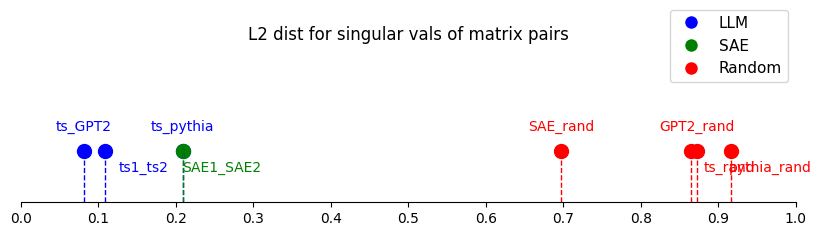

In [46]:
plot1D_L2dist_singvals(matPair_to_l2Dist_norma, norma_bool=True)

In [47]:
matPair_to_l2Dist_norma_LST = [ (v,k) for k,v in matPair_to_l2Dist_norma.items() ]
matPair_to_l2Dist_norma_LST.sort()
for v, k in matPair_to_l2Dist_norma_LST:
    print(v, k)

0.08137904 ts_GPT2
0.10865606 ts1_ts2
0.20848332 ts_pythia
0.2090404 SAE1_SAE2
0.6974652438623179 SAE_rand
0.8645485006976009 ts_rand
0.8725238289847242 GPT2_rand
0.9166755571278481 pythia_rand


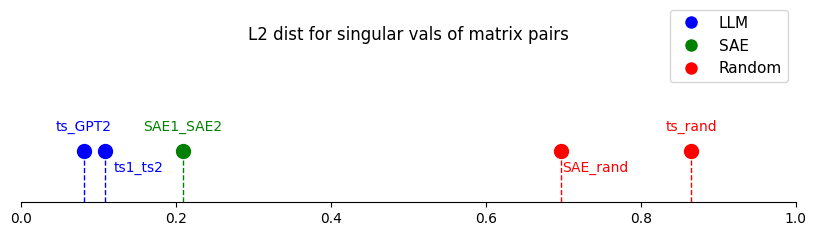

In [48]:
matPair_to_l2Dist_norma_2 = matPair_to_l2Dist_norma.copy()
del matPair_to_l2Dist_norma_2['ts_pythia']
del matPair_to_l2Dist_norma_2['pythia_rand']
del matPair_to_l2Dist_norma_2['GPT2_rand']

plot1D_L2dist_singvals(matPair_to_l2Dist_norma_2)

## labels in legend

(better for unnormalized)

In [34]:
def plot_L2dist_singvals(data):
    sorted_data = sorted(data.items(), key=lambda x: x[1])
    keys, values = zip(*sorted_data)

    colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))

    fig, ax = plt.subplots(figsize=(10, 4.5))  # Reduced height
    for i, (key, value) in enumerate(zip(keys, values)):
        ax.scatter(value, 0, color=colors[i], label=key, s=100)  # 's' adjusts the size of the point

    # for i, (value, key) in enumerate(zip(values, keys)):
    #     ax.annotate(key, (value, 0), xytext=(0, 10),
    #                 textcoords="offset points", ha='center', va='bottom',
    #                 rotation=45, fontsize=8)

    ax.set_ylim(-0.5, 0.5)  # Tighten y-axis
    ax.yaxis.set_visible(False)
    ax.set_title('L2 dist for singular vals of matrix pairs')
    ax.grid(True, axis='x')
    ax.legend(title="Key", loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

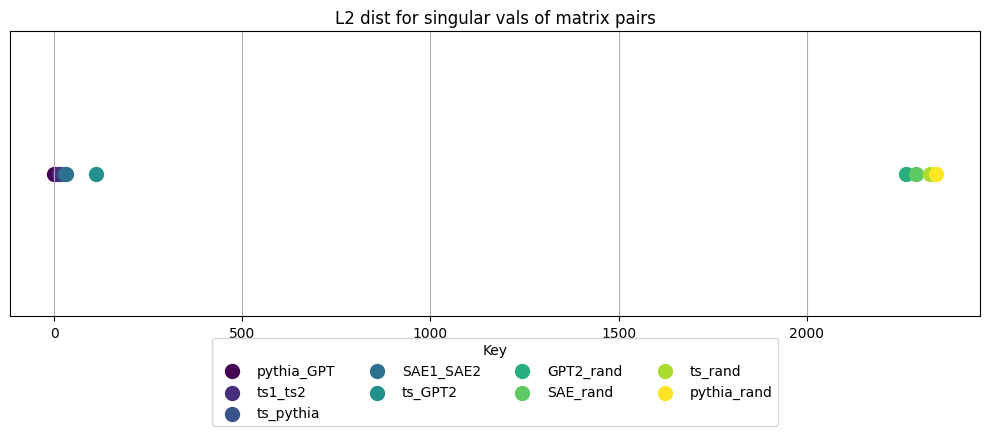

In [35]:
plot_L2dist_singvals(matPair_to_l2Dist)

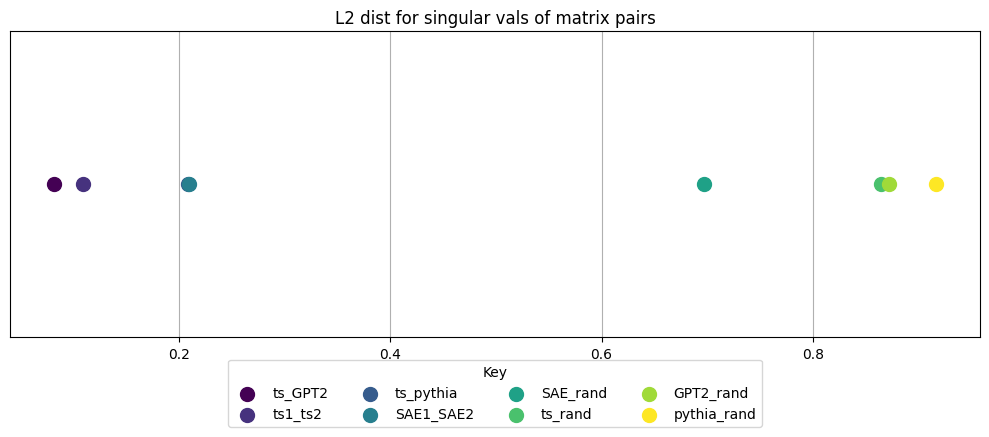

In [36]:
plot_L2dist_singvals(matPair_to_l2Dist_norma)